In [54]:
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import FashionMNIST

from torchvision.datasets import CIFAR10
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.utils import make_grid

import matplotlib.pyplot as plt

In [28]:
new_tensor = torch.tensor([[0,1,2], [3,4,5], [6,7,8]])
new_tensor

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]])

In [29]:
new_tensor.to('cuda')

AssertionError: Torch not compiled with CUDA enabled

In [30]:
a = torch.from_numpy(np.array([[0,1,2], [3,4,5], [6,7,8]]))
a

tensor([[0, 1, 2],
        [3, 4, 5],
        [6, 7, 8]], dtype=torch.int32)

In [31]:
torch.zeros(4,4)

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])

In [32]:
torch.ones(3,2,2)

tensor([[[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.]]])

In [33]:
training_data = FashionMNIST(
    root='assets/f_mnist',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [34]:
training_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [35]:
train_data_loader = DataLoader(training_data, batch_size=32, shuffle=True)

In [36]:
torch.cuda.is_available()

False

In [40]:
transform = Compose(
    [ToTensor(),
    Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]
)

training_data = CIFAR10(
    root='assets/cifar',
    train=True,
    download=True,
    transform=transform
)

test_data = CIFAR10(
    root='assets/cifar',
    train=False,
    download=True,
    transform=transform
)

100.0%


Extracting assets/cifar\cifar-10-python.tar.gz to assets/cifar
Files already downloaded and verified


In [41]:
batch_size = 5

train_data_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

In [43]:
for X, y in train_data_loader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([5, 3, 32, 32])
Shape of y: torch.Size([5]) torch.int64


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


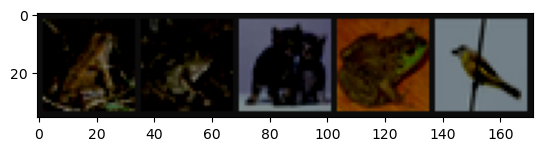

frog  frog  cat   frog  bird 


In [51]:
def imshow(img):
  img = img / 2 + .05 # revert normalization for viewing
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()
  
classes = training_data.classes
training_data.classes
#['airplane',
# 'automobile',
# 'bird',
# 'cat',
# 'deer',
# 'dog',
# 'frog',
# 'horse',
# 'ship',
# 'truck']

dataiter = iter(train_data_loader)
images, labels = next(dataiter)
imshow(make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [56]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        return self.linear_relu_stack(x)
    
model = NeuralNetwork()

In [57]:
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.001 )

In [60]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 2000 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [61]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [62]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_data_loader, model, loss_fn, optimizer)
    test(test_data_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.315352  [    0/50000]
loss: 2.132724  [10000/50000]
loss: 1.843455  [20000/50000]
loss: 1.887826  [30000/50000]
loss: 1.999697  [40000/50000]
Test Error: 
 Accuracy: 37.9%, Avg loss: 1.766152 

Epoch 2
-------------------------------
loss: 1.628334  [    0/50000]
loss: 1.312815  [10000/50000]
loss: 1.564107  [20000/50000]
loss: 1.252832  [30000/50000]
loss: 2.509534  [40000/50000]
Test Error: 
 Accuracy: 43.7%, Avg loss: 1.611767 

Epoch 3
-------------------------------
loss: 1.016887  [    0/50000]
loss: 1.022592  [10000/50000]
loss: 2.330357  [20000/50000]
loss: 1.304668  [30000/50000]
loss: 0.963194  [40000/50000]
Test Error: 
 Accuracy: 46.3%, Avg loss: 1.533701 

Epoch 4
-------------------------------
loss: 1.112357  [    0/50000]
loss: 1.643126  [10000/50000]
loss: 1.646065  [20000/50000]
loss: 1.437369  [30000/50000]
loss: 1.212695  [40000/50000]
Test Error: 
 Accuracy: 48.2%, Avg loss: 1.470781 

Epoch 5
------------------------